# Objetivo:

El Objetivo de este notebook es compartir las funciones recurrentes que uso en mi dia a dia como risk data scientist.

#### Previo:

Cargaremos un dataset de ejemplo que nos provee la libreria catboost el cual es el Amazon Employee Access Challenge se introdujo como parte de una competición organizada por Kaggle.

El objetivo de la competencia era predecir si se concedería o no la solicitud de un empleado de Amazon para acceder a cierto recurso.

El conjunto de datos es una forma anonimizada de tales solicitudes con una variable binaria que indica si se concedió el acceso o no. Cada fila corresponde a una solicitud de acceso distinta, y cada columna corresponde a una característica anonimizada, que podría ser cualquier tipo de información proporcionada en la solicitud.

La columna 'ACTION' es la variable objetivo. Un valor de 1 significa que se aprobó la solicitud de acceso, y un valor de 0 significa que la solicitud fue denegada. Este es un problema de clasificación binaria: el objetivo es predecir con precisión si se aprobará o denegará una futura solicitud de acceso, dada cierta información.

In [1]:
!pip install catboost

In [2]:
from catboost import datasets, CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load dataset
train_df, test_df = datasets.amazon()

In [3]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [6]:
# Define target variable
y = train_df["ACTION"]

# Drop target variable from the train set
X = train_df.drop("ACTION", axis=1)

# Split dataset into train and validation parts
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

Nota : En el anteior codigo los terminos X_validation, y_validation son tambien conocidos en plantillas de modelos de riesgos como df_test, y_test o tambien df_oot, y_oot donde oot significa "fuera de tiempo" (out of time) el cual hace referencia a ejecutar el modelo sobre un periodo desde el cual no ha sido entrenado para ver como se comporta el performance del modelo

In [7]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=100, 
                           depth=2, 
                           learning_rate=0.1, 
                           loss_function='Logloss')

# Fit model
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), verbose=False)

In [9]:
# Get predictions
preds_class_train = model.predict(X_train)
preds_class_validation = model.predict(X_validation)

# Calculate accuracy
acc_train = accuracy_score(y_train, preds_class_train)
acc_validation = accuracy_score(y_validation, preds_class_validation)

print("Accuracy Train: {:.2f}%".format(acc_train * 100))
print("Accuracy Validation: {:.2f}%".format(acc_validation * 100))

Accuracy Train: 94.17%
Accuracy Validation: 94.37%


Nota : En el anterior codigo validation es tambien conocido en los modelos de riesgo como OOT o TEST

##  Calculo de Indicadores GINI, KS, ROC

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

Nota: roc_auc_score(y_oot,y_pred_val) = roc_auc_score(y_validation, preds_class_validation)


Nota: roc_auc_score(y_train,y_pred) = roc_auc_score(y_train, preds_class_train)

In [11]:
#GINI
print("Gini Fuera Tiempo: ",2*roc_auc_score(y_validation, preds_class_validation)-1)
print("Gini Desarrollo: ",2*roc_auc_score(y_train, preds_class_train)-1)

Gini Fuera Tiempo:  0.0
Gini Desarrollo:  0.0


In [13]:
#ROC
print("ROC fuera Tiempo: ",roc_auc_score(y_validation, preds_class_validation))
print("ROC Desarrollo: ",roc_auc_score(y_train, preds_class_train))

ROC fuera Tiempo:  0.5
ROC Desarrollo:  0.5


In [15]:
#KS
import numpy as np

def ks_statistic(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    ks = np.max(tpr - fpr)
    return ks

ks = ks_statistic(y_validation, preds_class_validation)
print('KS fuera de tiempo:', ks)
ks2 = ks_statistic(y_train, preds_class_train)
print('KS Desarrollo:', ks2)

KS fuera de tiempo: 0.0
KS Desarrollo: 0.0


## Calculo de Gini mensual

In [ ]:
from catboost import CatBoostClassifier
#model es un CatBoostClassifier

In [ ]:
#Lista de meses a calcular GINI
periodos = (202106,202107,202108,202109,202110)

#features
var_x = []
for col in df_train2.columns:
    var_x.append(col)

#GINI
for i in periodos:
    y_aux = df_desarrollo.loc[df_desarrollo['codmes']==i, 'tm60_12'].reset_index(drop=True)
    #antes de predict va el objeto booster modelo
    #Este es el caso se este usando un modelo de tipo catboost
    y_pred = model.predict_proba(df_desarrollo.loc[df_desarrollo['codmes'] == i, var_x].reset_index(
            drop=True))[:,1]
    lr_auc = roc_auc_score(y_aux, y_pred)  
    gini = 2*lr_auc-1
    print('GINI '+str(i)+': '+str(gini))

## Calculo de Score

In [ ]:
y_pred_val=model.predict_proba(df_oot2)[:, 1]

In [ ]:
# Calculate the predicted score as the complement of y_pred_val, multiplied by 1000
y_pred_val_1 = (1 - y_pred_val) * 1000

# Round the predicted score to the nearest integer and assign it to a new column in the dataframe
df_oot['score'] = np.round(y_pred_val_1)

# Convert the values in the 'score_nobank_tc' column to integers
df_oot["score"] = df_oot["score"].astype("int")

## Tabla de Eficiencia

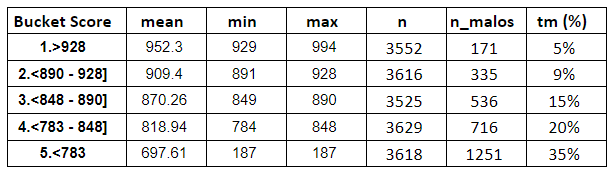

In [ ]:
#División en 5 
df_oot['bucket_score'] = pd.qcut(df_oot['score_nobank_tc'], q=5, precision=0)

El resultado final debe ser algo asi

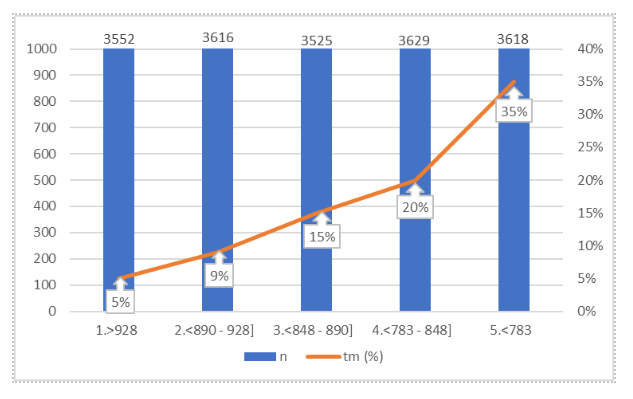

### Opción 1 si tiene poca data

In [ ]:
!pip install PivotTableJS

In [ ]:
#Usar esta ultima tabla con pivot_ui para ver los valores por buckets
df_oot_2 = df_oot[['bucket_score','score_nobank_tc','tm60_12']].copy()

In [ ]:
from pivottablejs import pivot_ui

#Aqui seleccionar en la columna vertical los buckets y en la columna horizontal superior las columnas
pivot_ui(df_oot_2)

### Opción 2 si hay mucha data

In [ ]:
#Usar groupby